<a href="https://colab.research.google.com/github/Hacxmr/log-analysis/blob/main/Supervised_CIC_IDS_2017.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import files
uploaded = files.upload()  # Choose CIC-IDS 2017.zip


Saving CIC-IDS 2017.zip to CIC-IDS 2017.zip


In [2]:
import zipfile
import os

zip_path = "CIC-IDS 2017.zip"
extract_path = "datasets"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("Extraction done.")



Extraction done.


In [3]:
import pandas as pd
import gc

# Path to the extracted CSVs
path = "datasets/"
files = [os.path.join(path, f) for f in os.listdir(path) if f.endswith('.csv')]

# Load and combine all CSVs
df_list = []
for file in files:
    print(f"Reading {file} ...")
    df = pd.read_csv(file, low_memory=False)
    df_list.append(df)
    gc.collect()

# Concatenate and save as Parquet
full_df = pd.concat(df_list, ignore_index=True)
full_df.to_parquet("cic_ids_2017.parquet")

print("Saved as cic_ids_2017.parquet")



Reading datasets/Friday-WorkingHours-Morning.pcap_ISCX.csv ...
Reading datasets/Tuesday-WorkingHours.pcap_ISCX.csv ...
Reading datasets/Monday-WorkingHours.pcap_ISCX.csv ...
Reading datasets/Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv ...
Reading datasets/Friday-WorkingHours-Afternoon-PortScan.pcap_ISCX.csv ...
Reading datasets/Thursday-WorkingHours-Afternoon-Infilteration.pcap_ISCX.csv ...
Reading datasets/Thursday-WorkingHours-Morning-WebAttacks.pcap_ISCX.csv ...
Reading datasets/Wednesday-workingHours.pcap_ISCX.csv ...
Saved as cic_ids_2017.parquet


In [2]:
# Load parquet file
import pandas as pd
df = pd.read_parquet("cic_ids_2017.parquet")

# Display columns to check for the correct 'Label' column name
print("Columns in DataFrame:")
print(df.columns)

# Strip leading/trailing whitespace from column names
df.columns = df.columns.str.strip()

# Drop missing values or irrelevant ones
df = df.dropna()
df = df.loc[:, ~df.columns.str.contains('^Unnamed')]

# Assume 'Label' column is the target (common in CIC datasets)
# Use the stripped column name for 'Label'
X = df.drop(columns=['Label'])
y = df['Label']

# Convert categorical columns (if any)
X = pd.get_dummies(X)



Columns in DataFrame:
Index([' Destination Port', ' Flow Duration', ' Total Fwd Packets',
       ' Total Backward Packets', 'Total Length of Fwd Packets',
       ' Total Length of Bwd Packets', ' Fwd Packet Length Max',
       ' Fwd Packet Length Min', ' Fwd Packet Length Mean',
       ' Fwd Packet Length Std', 'Bwd Packet Length Max',
       ' Bwd Packet Length Min', ' Bwd Packet Length Mean',
       ' Bwd Packet Length Std', 'Flow Bytes/s', ' Flow Packets/s',
       ' Flow IAT Mean', ' Flow IAT Std', ' Flow IAT Max', ' Flow IAT Min',
       'Fwd IAT Total', ' Fwd IAT Mean', ' Fwd IAT Std', ' Fwd IAT Max',
       ' Fwd IAT Min', 'Bwd IAT Total', ' Bwd IAT Mean', ' Bwd IAT Std',
       ' Bwd IAT Max', ' Bwd IAT Min', 'Fwd PSH Flags', ' Bwd PSH Flags',
       ' Fwd URG Flags', ' Bwd URG Flags', ' Fwd Header Length',
       ' Bwd Header Length', 'Fwd Packets/s', ' Bwd Packets/s',
       ' Min Packet Length', ' Max Packet Length', ' Packet Length Mean',
       ' Packet Length Std', ' Pack

In [6]:
import numpy as np

X.replace([np.inf, -np.inf], np.nan, inplace=True)

# Fill remaining NaN values (after replacing inf) with the mean of the column
# You could also use median or a constant like 0 depending on the data
X.fillna(X.mean(), inplace=True)


In [7]:
X_sample = X.sample(frac=0.1, random_state=42)
y_sample = y.loc[X_sample.index]

X_train, X_test, y_train, y_test = train_test_split(X_sample, y_sample, test_size=0.2, random_state=42)


In [8]:
clf = RandomForestClassifier(n_estimators=20, random_state=42)
clf.fit(X_train, y_train)

# 📈 Evaluate the model
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


                          precision    recall  f1-score   support

                  BENIGN       1.00      1.00      1.00     45514
                     Bot       0.96      0.46      0.62        48
                    DDoS       1.00      1.00      1.00      2497
           DoS GoldenEye       1.00      0.99      0.99       185
                DoS Hulk       1.00      1.00      1.00      4611
        DoS Slowhttptest       0.98      0.99      0.99       116
           DoS slowloris       1.00      0.98      0.99       113
             FTP-Patator       1.00      0.99      1.00       158
              Heartbleed       1.00      1.00      1.00         1
            Infiltration       0.00      0.00      0.00         1
                PortScan       1.00      1.00      1.00      3178
             SSH-Patator       1.00      1.00      1.00       112
Web Attack � Brute Force       0.80      0.80      0.80        41
        Web Attack � XSS       0.25      0.15      0.19        13

        

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [9]:
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")


Accuracy: 0.9983


<Figure size 600x500 with 0 Axes>

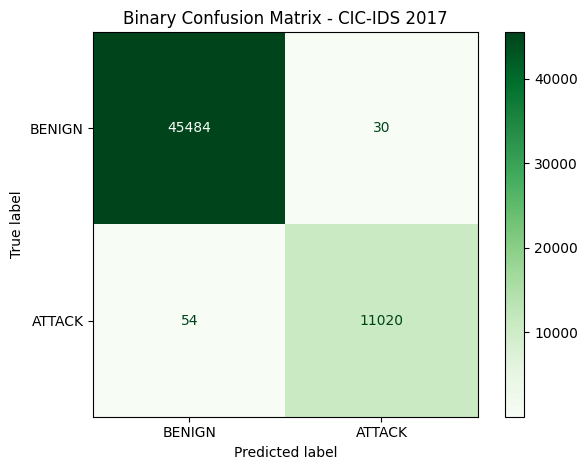

In [12]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Convert to binary labels
y_test_binary = y_test.apply(lambda x: 'BENIGN' if x == 'BENIGN' else 'ATTACK')
y_pred_binary = pd.Series(y_pred, index=y_test.index).apply(lambda x: 'BENIGN' if x == 'BENIGN' else 'ATTACK')

# Compute binary confusion matrix
cm = confusion_matrix(y_test_binary, y_pred_binary, labels=['BENIGN', 'ATTACK'])


# Plot
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['BENIGN', 'ATTACK'])
plt.figure(figsize=(6, 5))
disp.plot(cmap="Greens")
plt.title("Binary Confusion Matrix - CIC-IDS 2017")
plt.tight_layout()
plt.show()
